In [1]:
import os, kagglehub, pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import torch, torch.nn as nn, torch.nn.functional as F

# ─── Load dataset ───────────────────────────────────────────────
path = kagglehub.dataset_download("atharvasoundankar/gen-ai-misinformation-detection-datase-20242025")
for f in os.listdir(path):
    if f.endswith(".csv"):
        df = pd.read_csv(os.path.join(path, f))
        break

keep = ["text_length","num_hashtags","sentiment_score","num_urls","num_mentions",
        "month","author_followers","source_domain_reliability","is_misinformation"]
df = df[keep].copy()

# Fix month → numeric
if df["month"].dtype == "object":
    month_map = {m: i+1 for i, m in enumerate([
        "January","February","March","April","May","June","July","August",
        "September","October","November","December"
    ])}
    df["month"] = df["month"].map(month_map).fillna(0).astype(int)

# Log-scale skewed columns
for c in ["author_followers","num_urls","num_mentions"]:
    df[c] = np.log1p(df[c])

# Add interaction features
df["hashtag_density"] = df["num_hashtags"] / (df["text_length"] + 1e-6)
df["emotional_amplifier"] = np.abs(df["sentiment_score"]) * df["num_hashtags"]
df["short_high_sentiment"] = (df["text_length"] < df["text_length"].median()) * np.abs(df["sentiment_score"])
df = df.fillna(0)

X = df.drop(columns=["is_misinformation"])
y = df["is_misinformation"]

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ─── 1. LightGBM ────────────────────────────────────────────────
gbm = lgb.LGBMClassifier(
    objective="binary",
    learning_rate=0.02,
    n_estimators=1200,
    num_leaves=32,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=0.2,
    random_state=42,
    verbosity=-1
)
gbm.fit(Xtr, ytr)
gbm_pred = gbm.predict_proba(Xte)[:,1]

# ─── 2. Logistic Regression ─────────────────────────────────────
scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr)
Xte_s = scaler.transform(Xte)
logreg = LogisticRegression(max_iter=2000, solver="lbfgs")
logreg.fit(Xtr_s, ytr)
log_pred = logreg.predict_proba(Xte_s)[:,1]

# ─── 3. Small Neural Net ────────────────────────────────────────
Xtr_t = torch.tensor(Xtr_s, dtype=torch.float32)
ytr_t = torch.tensor(ytr.values, dtype=torch.float32)
Xte_t = torch.tensor(Xte_s, dtype=torch.float32)
device = "cuda" if torch.cuda.is_available() else "cpu"

class TinyMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, 32), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(32, 1)
        )
    def forward(self, x): return self.net(x).squeeze(1)

mlp = TinyMLP(Xtr_t.shape[1]).to(device)
opt = torch.optim.AdamW(mlp.parameters(), lr=2e-3, weight_decay=1e-4)
loss_fn = nn.BCEWithLogitsLoss()
Xtr_t, ytr_t = Xtr_t.to(device), ytr_t.to(device)
Xte_t = Xte_t.to(device)

for epoch in range(300):
    mlp.train(); opt.zero_grad()
    out = mlp(Xtr_t)
    loss = loss_fn(out, ytr_t)
    loss.backward(); opt.step()

mlp.eval()
with torch.no_grad():
    mlp_pred = torch.sigmoid(mlp(Xte_t)).cpu().numpy()

# ─── Ensemble average (soft voting) ─────────────────────────────
ensemble_pred = (gbm_pred + log_pred + mlp_pred) / 3.0
ensemble_cls = (ensemble_pred > 0.5).astype(int)

print(f"Accuracy: {accuracy_score(yte, ensemble_cls):.3f}")
print(f"F1: {f1_score(yte, ensemble_cls):.3f}")
print(f"ROC-AUC: {roc_auc_score(yte, ensemble_pred):.3f}")


/home/rameyjm7/workspace/ml-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Accuracy: 0.500
F1: 0.554
ROC-AUC: 0.553


In [2]:
import os, time, optuna, kagglehub, pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import torch, torch.nn as nn

# ── Load & preprocess once ───────────────────────────────────────
path = kagglehub.dataset_download("atharvasoundankar/gen-ai-misinformation-detection-datase-20242025")
for f in os.listdir(path):
    if f.endswith(".csv"): df = pd.read_csv(os.path.join(path, f)); break

keep = ["text_length","num_hashtags","sentiment_score","num_urls","num_mentions",
        "month","author_followers","source_domain_reliability","is_misinformation"]
df = df[keep].copy()
if df["month"].dtype=="object":
    month_map={m:i+1 for i,m in enumerate([
        "January","February","March","April","May","June","July","August",
        "September","October","November","December"])}
    df["month"]=df["month"].map(month_map).fillna(0).astype(int)

for c in ["author_followers","num_urls","num_mentions"]:
    df[c]=np.log1p(df[c])
df["hashtag_density"]=df["num_hashtags"]/(df["text_length"]+1e-6)
df["emotional_amplifier"]=np.abs(df["sentiment_score"])*df["num_hashtags"]
df["short_high_sentiment"]=(df["text_length"]<df["text_length"].median())*np.abs(df["sentiment_score"])
df["sentiment_x_reliability"] = df["sentiment_score"] * df["source_domain_reliability"]
df["hashtags_x_urls"] = df["num_hashtags"] * np.log1p(df["num_urls"])
df["engagement_norm"] = (df["author_followers"] + 1) * (df["num_mentions"] + 1)
df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
df["month_cos"] = np.cos(2*np.pi*df["month"]/12)

df=df.fillna(0)

X=df.drop(columns=["is_misinformation"])
y=df["is_misinformation"]
Xtr,Xte,ytr,yte=train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

# Logistic regression baseline (fixed)
scaler=StandardScaler()
Xtr_s=scaler.fit_transform(Xtr); Xte_s=scaler.transform(Xte)
logreg=LogisticRegression(max_iter=3000,solver="lbfgs")
logreg.fit(Xtr_s,ytr)
log_pred=logreg.predict_proba(Xte_s)[:,1]

# PyTorch MLP
class MLP(nn.Module):
    def __init__(self,in_dim,h1,h2,drop):
        super().__init__()
        self.seq=nn.Sequential(
            nn.Linear(in_dim,h1),nn.GELU(),nn.Dropout(drop),
            nn.Linear(h1,h2),nn.GELU(),nn.Dropout(drop),
            nn.Linear(h2,1)
        )
    def forward(self,x): return self.seq(x).squeeze(1)

device="cuda" if torch.cuda.is_available() else "cpu"
Xtr_t=torch.tensor(Xtr_s,dtype=torch.float32).to(device)
ytr_t=torch.tensor(ytr.values,dtype=torch.float32).to(device)
Xte_t=torch.tensor(Xte_s,dtype=torch.float32).to(device)

# ── Optuna objective ─────────────────────────────────────────────
def objective(trial):
    # LightGBM params
    lr_lgb  = trial.suggest_float("lgb_lr", 0.003, 0.05, log=True)
    leaves  = trial.suggest_int("lgb_leaves", 16, 128, log=True)
    depth   = trial.suggest_int("lgb_depth", 3, 10)
    subsamp = trial.suggest_float("lgb_subsample", 0.7, 1.0)
    reg_l   = trial.suggest_float("lgb_reg", 0.05, 1.0)
    child   = trial.suggest_int("lgb_child", 5, 30)
    estim   = trial.suggest_int("lgb_estimators", 800, 2500)

    gbm = lgb.LGBMClassifier(
        objective="binary", learning_rate=lr_lgb,
        num_leaves=leaves, max_depth=depth,
        subsample=subsamp, colsample_bytree=0.9,
        reg_lambda=reg_l, min_child_samples=child,
        n_estimators=estim, random_state=42, verbosity=-1
    )
    gbm.fit(Xtr, ytr)
    gbm_pred = gbm.predict_proba(Xte)[:,1]

    # MLP params
    h1 = trial.suggest_int("mlp_h1", 64, 512, log=True)
    h2 = trial.suggest_int("mlp_h2", 32, 256, log=True)
    drop = trial.suggest_float("mlp_drop", 0.2, 0.6)
    lr = trial.suggest_float("mlp_lr", 5e-5, 5e-3, log=True)
    epochs = trial.suggest_int("mlp_epochs", 200, 800)

    mlp = MLP(Xtr_t.shape[1], h1, h2, drop).to(device)
    opt = torch.optim.AdamW(mlp.parameters(), lr=lr, weight_decay=1e-4)
    loss_fn = nn.BCEWithLogitsLoss()
    scaler_amp = torch.amp.GradScaler('cuda')

    # train mlp
    mlp.train()
    for e in range(epochs):
        opt.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda'):
            out = mlp(Xtr_t)
            loss = loss_fn(out, ytr_t)
        scaler_amp.scale(loss).backward()
        scaler_amp.step(opt)
        scaler_amp.update()

    mlp.eval()
    with torch.no_grad(), torch.amp.autocast('cuda'):
        mlp_pred = torch.sigmoid(mlp(Xte_t)).cpu().numpy()

    # Ensemble
    ens = (gbm_pred + log_pred + mlp_pred)/3.0
    auc = roc_auc_score(yte, ens)
    return auc

# ── Run optimization ────────────────────────────────────────────
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40, show_progress_bar=True)

print("\n===== Best trial =====")
print(study.best_trial.params)
print(f"Best AUC: {study.best_value:.3f}")

# ── Optional: retrain best config fully ─────────────────────────
best = study.best_trial.params
gbm = lgb.LGBMClassifier(
    objective="binary",
    learning_rate=best["lgb_lr"],
    num_leaves=best["lgb_leaves"],
    max_depth=best["lgb_depth"],
    subsample=best["lgb_subsample"],
    colsample_bytree=0.9,
    reg_lambda=best["lgb_reg"],
    min_child_samples=best["lgb_child"],
    n_estimators=best["lgb_estimators"],
    random_state=42, verbosity=-1
)
gbm.fit(Xtr, ytr)
gbm_pred = gbm.predict_proba(Xte)[:,1]

mlp = MLP(Xtr_t.shape[1], best["mlp_h1"], best["mlp_h2"], best["mlp_drop"]).to(device)
opt = torch.optim.AdamW(mlp.parameters(), lr=best["mlp_lr"], weight_decay=1e-4)
loss_fn = nn.BCEWithLogitsLoss()
for e in range(best["mlp_epochs"]):
    opt.zero_grad(set_to_none=True)
    with torch.amp.autocast('cuda'):
        out = mlp(Xtr_t); loss = loss_fn(out, ytr_t)
    loss.backward(); opt.step()

mlp.eval()
with torch.no_grad(), torch.amp.autocast('cuda'):
    mlp_pred = torch.sigmoid(mlp(Xte_t)).cpu().numpy()
ensemble_pred = (gbm_pred + log_pred + mlp_pred)/3.0
ensemble_cls = (ensemble_pred>0.5).astype(int)

print(f"\nFinal Accuracy: {accuracy_score(yte, ensemble_cls):.3f}")
print(f"Final F1: {f1_score(yte, ensemble_cls):.3f}")
print(f"Final ROC-AUC: {roc_auc_score(yte, ensemble_pred):.3f}")


[I 2025-10-31 00:54:41,728] A new study created in memory with name: no-name-e4b7eb5f-2843-4ac4-ba6f-fe5976d3975d
Best trial: 0. Best value: 0.55314:   2%|▎         | 1/40 [00:03<02:12,  3.40s/it]

[I 2025-10-31 00:54:45,124] Trial 0 finished with value: 0.5531400966183575 and parameters: {'lgb_lr': 0.009675524296413007, 'lgb_leaves': 83, 'lgb_depth': 10, 'lgb_subsample': 0.9252423987159548, 'lgb_reg': 0.9000324891177589, 'lgb_child': 21, 'lgb_estimators': 1948, 'mlp_h1': 310, 'mlp_h2': 174, 'mlp_drop': 0.29262206252541545, 'mlp_lr': 0.0003125380790862747, 'mlp_epochs': 717}. Best is trial 0 with value: 0.5531400966183575.


Best trial: 1. Best value: 0.61876:   5%|▌         | 2/40 [00:04<01:22,  2.18s/it]

[I 2025-10-31 00:54:46,452] Trial 1 finished with value: 0.6187600644122383 and parameters: {'lgb_lr': 0.005096767660399121, 'lgb_leaves': 17, 'lgb_depth': 3, 'lgb_subsample': 0.9052694483838674, 'lgb_reg': 0.6196967171286831, 'lgb_child': 19, 'lgb_estimators': 901, 'mlp_h1': 66, 'mlp_h2': 142, 'mlp_drop': 0.2135266027316691, 'mlp_lr': 5.9501065101241094e-05, 'mlp_epochs': 764}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:   8%|▊         | 3/40 [00:05<00:55,  1.51s/it]

[I 2025-10-31 00:54:47,166] Trial 2 finished with value: 0.5454911433172303 and parameters: {'lgb_lr': 0.026221657473809976, 'lgb_leaves': 56, 'lgb_depth': 5, 'lgb_subsample': 0.8008014003357787, 'lgb_reg': 0.8192751568499655, 'lgb_child': 8, 'lgb_estimators': 800, 'mlp_h1': 96, 'mlp_h2': 185, 'mlp_drop': 0.4227488457090878, 'mlp_lr': 0.0009306992497002887, 'mlp_epochs': 220}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  10%|█         | 4/40 [00:06<00:49,  1.38s/it]

[I 2025-10-31 00:54:48,358] Trial 3 finished with value: 0.5491143317230274 and parameters: {'lgb_lr': 0.03066049331337988, 'lgb_leaves': 18, 'lgb_depth': 9, 'lgb_subsample': 0.7767027028421296, 'lgb_reg': 0.4886348509914079, 'lgb_child': 7, 'lgb_estimators': 1073, 'mlp_h1': 85, 'mlp_h2': 84, 'mlp_drop': 0.31995974156094253, 'mlp_lr': 0.0017478319075008941, 'mlp_epochs': 220}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  12%|█▎        | 5/40 [00:08<00:52,  1.49s/it]

[I 2025-10-31 00:54:50,047] Trial 4 finished with value: 0.5495169082125604 and parameters: {'lgb_lr': 0.01706786075026677, 'lgb_leaves': 35, 'lgb_depth': 6, 'lgb_subsample': 0.8573048400428185, 'lgb_reg': 0.21717180642270612, 'lgb_child': 24, 'lgb_estimators': 2410, 'mlp_h1': 298, 'mlp_h2': 127, 'mlp_drop': 0.2302145966435842, 'mlp_lr': 0.00024277056814060423, 'mlp_epochs': 589}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  15%|█▌        | 6/40 [00:09<00:49,  1.45s/it]

[I 2025-10-31 00:54:51,407] Trial 5 finished with value: 0.568840579710145 and parameters: {'lgb_lr': 0.01830356065459364, 'lgb_leaves': 80, 'lgb_depth': 8, 'lgb_subsample': 0.7019158761989059, 'lgb_reg': 0.5723745343596119, 'lgb_child': 30, 'lgb_estimators': 1834, 'mlp_h1': 238, 'mlp_h2': 138, 'mlp_drop': 0.21427960794934686, 'mlp_lr': 0.00012062161646163838, 'mlp_epochs': 471}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  18%|█▊        | 7/40 [00:11<00:49,  1.51s/it]

[I 2025-10-31 00:54:53,041] Trial 6 finished with value: 0.5611916264090178 and parameters: {'lgb_lr': 0.007053185375418067, 'lgb_leaves': 23, 'lgb_depth': 4, 'lgb_subsample': 0.803395177703902, 'lgb_reg': 0.9770334403764893, 'lgb_child': 5, 'lgb_estimators': 2151, 'mlp_h1': 352, 'mlp_h2': 72, 'mlp_drop': 0.2694682823000096, 'mlp_lr': 0.0005584285443537311, 'mlp_epochs': 579}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  20%|██        | 8/40 [00:12<00:45,  1.43s/it]

[I 2025-10-31 00:54:54,287] Trial 7 finished with value: 0.5982286634460547 and parameters: {'lgb_lr': 0.0042034569446488465, 'lgb_leaves': 117, 'lgb_depth': 9, 'lgb_subsample': 0.9754682070554845, 'lgb_reg': 0.3775758447702907, 'lgb_child': 29, 'lgb_estimators': 1773, 'mlp_h1': 77, 'mlp_h2': 231, 'mlp_drop': 0.3898825658168872, 'mlp_lr': 0.00015919627132794938, 'mlp_epochs': 388}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  22%|██▎       | 9/40 [00:13<00:39,  1.26s/it]

[I 2025-10-31 00:54:55,196] Trial 8 finished with value: 0.5978260869565217 and parameters: {'lgb_lr': 0.014325420610573472, 'lgb_leaves': 35, 'lgb_depth': 4, 'lgb_subsample': 0.9724728070006732, 'lgb_reg': 0.10930706606648084, 'lgb_child': 26, 'lgb_estimators': 904, 'mlp_h1': 79, 'mlp_h2': 36, 'mlp_drop': 0.5023324999879188, 'mlp_lr': 5.539970725869296e-05, 'mlp_epochs': 454}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  25%|██▌       | 10/40 [00:15<00:46,  1.55s/it]

[I 2025-10-31 00:54:57,398] Trial 9 finished with value: 0.5471014492753623 and parameters: {'lgb_lr': 0.009139017584680586, 'lgb_leaves': 86, 'lgb_depth': 9, 'lgb_subsample': 0.748698257224647, 'lgb_reg': 0.1471793921526658, 'lgb_child': 15, 'lgb_estimators': 1646, 'mlp_h1': 344, 'mlp_h2': 38, 'mlp_drop': 0.43395928834160824, 'mlp_lr': 7.341339572684976e-05, 'mlp_epochs': 532}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  28%|██▊       | 11/40 [00:17<00:43,  1.51s/it]

[I 2025-10-31 00:54:58,808] Trial 10 finished with value: 0.5974235104669887 and parameters: {'lgb_lr': 0.0031536666793598334, 'lgb_leaves': 18, 'lgb_depth': 3, 'lgb_subsample': 0.8837347922050242, 'lgb_reg': 0.6807242338888979, 'lgb_child': 14, 'lgb_estimators': 1333, 'mlp_h1': 143, 'mlp_h2': 66, 'mlp_drop': 0.584866795400975, 'mlp_lr': 0.004635967662813769, 'mlp_epochs': 777}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  30%|███       | 12/40 [00:18<00:39,  1.42s/it]

[I 2025-10-31 00:55:00,031] Trial 11 finished with value: 0.6002415458937198 and parameters: {'lgb_lr': 0.0041423712746966245, 'lgb_leaves': 126, 'lgb_depth': 7, 'lgb_subsample': 0.9895677663334643, 'lgb_reg': 0.3661352256881226, 'lgb_child': 18, 'lgb_estimators': 1476, 'mlp_h1': 64, 'mlp_h2': 243, 'mlp_drop': 0.34734978122768895, 'mlp_lr': 0.00015063141260487074, 'mlp_epochs': 341}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  32%|███▎      | 13/40 [00:19<00:38,  1.43s/it]

[I 2025-10-31 00:55:01,464] Trial 12 finished with value: 0.5801127214170693 and parameters: {'lgb_lr': 0.005278983833457518, 'lgb_leaves': 50, 'lgb_depth': 7, 'lgb_subsample': 0.9307849793229174, 'lgb_reg': 0.3535015136898797, 'lgb_child': 19, 'lgb_estimators': 1354, 'mlp_h1': 137, 'mlp_h2': 253, 'mlp_drop': 0.3474186139265545, 'mlp_lr': 5.067593170441554e-05, 'mlp_epochs': 347}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  35%|███▌      | 14/40 [00:21<00:38,  1.49s/it]

[I 2025-10-31 00:55:03,089] Trial 13 finished with value: 0.5708534621578101 and parameters: {'lgb_lr': 0.0031776375524265707, 'lgb_leaves': 28, 'lgb_depth': 6, 'lgb_subsample': 0.9994255176728654, 'lgb_reg': 0.7086087515466221, 'lgb_child': 13, 'lgb_estimators': 1377, 'mlp_h1': 65, 'mlp_h2': 111, 'mlp_drop': 0.49056644977479474, 'mlp_lr': 0.00011410919284583891, 'mlp_epochs': 678}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  38%|███▊      | 15/40 [00:22<00:33,  1.32s/it]

[I 2025-10-31 00:55:04,036] Trial 14 finished with value: 0.6086956521739131 and parameters: {'lgb_lr': 0.00543600420682176, 'lgb_leaves': 62, 'lgb_depth': 7, 'lgb_subsample': 0.9163886003122939, 'lgb_reg': 0.35022055928311424, 'lgb_child': 22, 'lgb_estimators': 1105, 'mlp_h1': 120, 'mlp_h2': 171, 'mlp_drop': 0.3609604459737703, 'mlp_lr': 0.0002658311038108678, 'mlp_epochs': 328}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  40%|████      | 16/40 [00:23<00:32,  1.33s/it]

[I 2025-10-31 00:55:05,397] Trial 15 finished with value: 0.5346215780998389 and parameters: {'lgb_lr': 0.04619127025755202, 'lgb_leaves': 62, 'lgb_depth': 3, 'lgb_subsample': 0.9033917339722167, 'lgb_reg': 0.5887946345820642, 'lgb_child': 23, 'lgb_estimators': 1044, 'mlp_h1': 121, 'mlp_h2': 165, 'mlp_drop': 0.25961828672510995, 'mlp_lr': 0.00045843041264654385, 'mlp_epochs': 798}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  42%|████▎     | 17/40 [00:24<00:29,  1.28s/it]

[I 2025-10-31 00:55:06,542] Trial 16 finished with value: 0.5615942028985507 and parameters: {'lgb_lr': 0.006302002932276102, 'lgb_leaves': 41, 'lgb_depth': 5, 'lgb_subsample': 0.8517396207982522, 'lgb_reg': 0.4693588405131268, 'lgb_child': 26, 'lgb_estimators': 1142, 'mlp_h1': 183, 'mlp_h2': 102, 'mlp_drop': 0.20042891871287113, 'mlp_lr': 0.000946803210333381, 'mlp_epochs': 292}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  45%|████▌     | 18/40 [00:26<00:29,  1.35s/it]

[I 2025-10-31 00:55:08,070] Trial 17 finished with value: 0.6026570048309179 and parameters: {'lgb_lr': 0.009531401754074543, 'lgb_leaves': 24, 'lgb_depth': 8, 'lgb_subsample': 0.9468893197103841, 'lgb_reg': 0.24971125267386693, 'lgb_child': 20, 'lgb_estimators': 1217, 'mlp_h1': 108, 'mlp_h2': 52, 'mlp_drop': 0.47845219871409883, 'mlp_lr': 0.0002435475521910817, 'mlp_epochs': 651}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  48%|████▊     | 19/40 [00:27<00:26,  1.26s/it]

[I 2025-10-31 00:55:09,120] Trial 18 finished with value: 0.5825281803542672 and parameters: {'lgb_lr': 0.005254043209601591, 'lgb_leaves': 68, 'lgb_depth': 5, 'lgb_subsample': 0.8850103315486153, 'lgb_reg': 0.7048985215099208, 'lgb_child': 11, 'lgb_estimators': 940, 'mlp_h1': 460, 'mlp_h2': 143, 'mlp_drop': 0.5451090148900717, 'mlp_lr': 8.175198664797842e-05, 'mlp_epochs': 422}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  50%|█████     | 20/40 [00:28<00:24,  1.23s/it]

[I 2025-10-31 00:55:10,280] Trial 19 finished with value: 0.5422705314009661 and parameters: {'lgb_lr': 0.0075200653461288975, 'lgb_leaves': 16, 'lgb_depth': 7, 'lgb_subsample': 0.8256061409942927, 'lgb_reg': 0.2638485883398283, 'lgb_child': 16, 'lgb_estimators': 811, 'mlp_h1': 184, 'mlp_h2': 105, 'mlp_drop': 0.38666281307650635, 'mlp_lr': 0.0020188775341212556, 'mlp_epochs': 529}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  52%|█████▎    | 21/40 [00:29<00:22,  1.18s/it]

[I 2025-10-31 00:55:11,356] Trial 20 finished with value: 0.5801127214170693 and parameters: {'lgb_lr': 0.0043222113958409246, 'lgb_leaves': 43, 'lgb_depth': 4, 'lgb_subsample': 0.9018820896382661, 'lgb_reg': 0.46244690855200077, 'lgb_child': 22, 'lgb_estimators': 1587, 'mlp_h1': 159, 'mlp_h2': 198, 'mlp_drop': 0.3093289040648585, 'mlp_lr': 0.0005229970466966936, 'mlp_epochs': 274}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  55%|█████▌    | 22/40 [00:31<00:23,  1.30s/it]

[I 2025-10-31 00:55:12,910] Trial 21 finished with value: 0.5933977455716586 and parameters: {'lgb_lr': 0.010151701240871152, 'lgb_leaves': 23, 'lgb_depth': 8, 'lgb_subsample': 0.9385299614184206, 'lgb_reg': 0.053778438661337524, 'lgb_child': 20, 'lgb_estimators': 1176, 'mlp_h1': 107, 'mlp_h2': 52, 'mlp_drop': 0.4653231261144697, 'mlp_lr': 0.00025920906647966947, 'mlp_epochs': 668}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  57%|█████▊    | 23/40 [00:32<00:24,  1.41s/it]

[I 2025-10-31 00:55:14,596] Trial 22 finished with value: 0.5768921095008052 and parameters: {'lgb_lr': 0.011572199220668036, 'lgb_leaves': 23, 'lgb_depth': 8, 'lgb_subsample': 0.9545250055909488, 'lgb_reg': 0.2774353614429249, 'lgb_child': 18, 'lgb_estimators': 1217, 'mlp_h1': 109, 'mlp_h2': 48, 'mlp_drop': 0.5372090343491442, 'mlp_lr': 0.00021018838412558042, 'mlp_epochs': 727}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  60%|██████    | 24/40 [00:34<00:22,  1.38s/it]

[I 2025-10-31 00:55:15,898] Trial 23 finished with value: 0.5994363929146538 and parameters: {'lgb_lr': 0.007823098042463554, 'lgb_leaves': 27, 'lgb_depth': 6, 'lgb_subsample': 0.9062887723140266, 'lgb_reg': 0.21794703871423363, 'lgb_child': 26, 'lgb_estimators': 1049, 'mlp_h1': 94, 'mlp_h2': 57, 'mlp_drop': 0.45439050268872117, 'mlp_lr': 0.0003803425820105759, 'mlp_epochs': 621}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  62%|██████▎   | 25/40 [00:36<00:22,  1.52s/it]

[I 2025-10-31 00:55:17,753] Trial 24 finished with value: 0.5877616747181964 and parameters: {'lgb_lr': 0.0056839758687085105, 'lgb_leaves': 19, 'lgb_depth': 10, 'lgb_subsample': 0.8669706628749803, 'lgb_reg': 0.40314369520547, 'lgb_child': 24, 'lgb_estimators': 1240, 'mlp_h1': 121, 'mlp_h2': 85, 'mlp_drop': 0.5155597663363132, 'mlp_lr': 0.0007706207334761401, 'mlp_epochs': 741}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  65%|██████▌   | 26/40 [00:37<00:21,  1.53s/it]

[I 2025-10-31 00:55:19,301] Trial 25 finished with value: 0.5611916264090178 and parameters: {'lgb_lr': 0.013839336570619655, 'lgb_leaves': 31, 'lgb_depth': 8, 'lgb_subsample': 0.9547821149154581, 'lgb_reg': 0.6038171739069689, 'lgb_child': 16, 'lgb_estimators': 964, 'mlp_h1': 72, 'mlp_h2': 41, 'mlp_drop': 0.3552740079598716, 'mlp_lr': 8.949825793091108e-05, 'mlp_epochs': 670}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  68%|██████▊   | 27/40 [00:39<00:20,  1.54s/it]

[I 2025-10-31 00:55:20,871] Trial 26 finished with value: 0.6006441223832527 and parameters: {'lgb_lr': 0.004742458710897541, 'lgb_leaves': 20, 'lgb_depth': 7, 'lgb_subsample': 0.9205894921050148, 'lgb_reg': 0.31332513938869055, 'lgb_child': 20, 'lgb_estimators': 1455, 'mlp_h1': 94, 'mlp_h2': 122, 'mlp_drop': 0.5796206050680249, 'mlp_lr': 0.00019371007517208824, 'mlp_epochs': 620}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  70%|███████   | 28/40 [00:40<00:19,  1.60s/it]

[I 2025-10-31 00:55:22,604] Trial 27 finished with value: 0.5632045088566828 and parameters: {'lgb_lr': 0.008267208321710249, 'lgb_leaves': 16, 'lgb_depth': 6, 'lgb_subsample': 0.9487154277929897, 'lgb_reg': 0.7901069280544568, 'lgb_child': 17, 'lgb_estimators': 1255, 'mlp_h1': 204, 'mlp_h2': 161, 'mlp_drop': 0.41748148632292814, 'mlp_lr': 0.0003197952334359661, 'mlp_epochs': 775}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  72%|███████▎  | 29/40 [00:42<00:16,  1.54s/it]

[I 2025-10-31 00:55:24,000] Trial 28 finished with value: 0.570450885668277 and parameters: {'lgb_lr': 0.006542023923075751, 'lgb_leaves': 97, 'lgb_depth': 8, 'lgb_subsample': 0.8789209997103814, 'lgb_reg': 0.18014698130719783, 'lgb_child': 12, 'lgb_estimators': 931, 'mlp_h1': 143, 'mlp_h2': 74, 'mlp_drop': 0.23649035628748735, 'mlp_lr': 0.00011425564250745658, 'mlp_epochs': 510}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  75%|███████▌  | 30/40 [00:44<00:16,  1.64s/it]

[I 2025-10-31 00:55:25,874] Trial 29 finished with value: 0.5660225442834138 and parameters: {'lgb_lr': 0.0036400932424043193, 'lgb_leaves': 71, 'lgb_depth': 9, 'lgb_subsample': 0.8328511163209056, 'lgb_reg': 0.5166328586673548, 'lgb_child': 21, 'lgb_estimators': 1521, 'mlp_h1': 115, 'mlp_h2': 212, 'mlp_drop': 0.2861125866881003, 'mlp_lr': 0.001732323690221022, 'mlp_epochs': 718}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  78%|███████▊  | 31/40 [00:46<00:15,  1.74s/it]

[I 2025-10-31 00:55:27,841] Trial 30 finished with value: 0.5547504025764896 and parameters: {'lgb_lr': 0.010365221506807895, 'lgb_leaves': 53, 'lgb_depth': 10, 'lgb_subsample': 0.9151179533504569, 'lgb_reg': 0.4242262289978741, 'lgb_child': 22, 'lgb_estimators': 1972, 'mlp_h1': 222, 'mlp_h2': 150, 'mlp_drop': 0.46798682741762415, 'mlp_lr': 0.00036857717166828487, 'mlp_epochs': 686}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  80%|████████  | 32/40 [00:47<00:13,  1.69s/it]

[I 2025-10-31 00:55:29,410] Trial 31 finished with value: 0.5942028985507246 and parameters: {'lgb_lr': 0.004877925082437161, 'lgb_leaves': 21, 'lgb_depth': 7, 'lgb_subsample': 0.9256250081210879, 'lgb_reg': 0.3116340203031474, 'lgb_child': 20, 'lgb_estimators': 1428, 'mlp_h1': 91, 'mlp_h2': 121, 'mlp_drop': 0.5635675798112747, 'mlp_lr': 0.00018702157424052394, 'mlp_epochs': 627}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  82%|████████▎ | 33/40 [00:49<00:11,  1.59s/it]

[I 2025-10-31 00:55:30,778] Trial 32 finished with value: 0.5958132045088567 and parameters: {'lgb_lr': 0.0037300117935526833, 'lgb_leaves': 26, 'lgb_depth': 7, 'lgb_subsample': 0.9702700540226649, 'lgb_reg': 0.30871167123597226, 'lgb_child': 19, 'lgb_estimators': 1125, 'mlp_h1': 101, 'mlp_h2': 176, 'mlp_drop': 0.5903299767411165, 'mlp_lr': 0.00028165882274657205, 'mlp_epochs': 567}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  85%|████████▌ | 34/40 [00:50<00:09,  1.52s/it]

[I 2025-10-31 00:55:32,144] Trial 33 finished with value: 0.5998389694041868 and parameters: {'lgb_lr': 0.006092116982593506, 'lgb_leaves': 21, 'lgb_depth': 5, 'lgb_subsample': 0.9221483298174685, 'lgb_reg': 0.23806853251698437, 'lgb_child': 21, 'lgb_estimators': 1314, 'mlp_h1': 89, 'mlp_h2': 93, 'mlp_drop': 0.5199714875721895, 'mlp_lr': 0.00016493120558327184, 'mlp_epochs': 621}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  88%|████████▊ | 35/40 [00:51<00:07,  1.51s/it]

[I 2025-10-31 00:55:33,612] Trial 34 finished with value: 0.6010466988727858 and parameters: {'lgb_lr': 0.004680831860583684, 'lgb_leaves': 20, 'lgb_depth': 8, 'lgb_subsample': 0.8927968490675885, 'lgb_reg': 0.640593721867727, 'lgb_child': 24, 'lgb_estimators': 817, 'mlp_h1': 72, 'mlp_h2': 126, 'mlp_drop': 0.5590386501726295, 'mlp_lr': 0.00021819702572972025, 'mlp_epochs': 752}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  90%|█████████ | 36/40 [00:53<00:05,  1.49s/it]

[I 2025-10-31 00:55:35,078] Trial 35 finished with value: 0.5813204508856683 and parameters: {'lgb_lr': 0.018021833320992737, 'lgb_leaves': 16, 'lgb_depth': 9, 'lgb_subsample': 0.8889093827878368, 'lgb_reg': 0.8193566302651096, 'lgb_child': 24, 'lgb_estimators': 808, 'mlp_h1': 72, 'mlp_h2': 189, 'mlp_drop': 0.48546931488269907, 'mlp_lr': 0.0007199891098512461, 'mlp_epochs': 753}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  92%|█████████▎| 37/40 [00:54<00:04,  1.47s/it]

[I 2025-10-31 00:55:36,502] Trial 36 finished with value: 0.57085346215781 and parameters: {'lgb_lr': 0.027753487989431384, 'lgb_leaves': 31, 'lgb_depth': 8, 'lgb_subsample': 0.8656059287524451, 'lgb_reg': 0.6497973056470082, 'lgb_child': 28, 'lgb_estimators': 1011, 'mlp_h1': 80, 'mlp_h2': 136, 'mlp_drop': 0.43763869922413223, 'mlp_lr': 6.841120664357304e-05, 'mlp_epochs': 701}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  95%|█████████▌| 38/40 [00:56<00:02,  1.49s/it]

[I 2025-10-31 00:55:38,035] Trial 37 finished with value: 0.5986312399355878 and parameters: {'lgb_lr': 0.008330661286268711, 'lgb_leaves': 39, 'lgb_depth': 9, 'lgb_subsample': 0.8378189008513028, 'lgb_reg': 0.766390331715971, 'lgb_child': 25, 'lgb_estimators': 866, 'mlp_h1': 72, 'mlp_h2': 151, 'mlp_drop': 0.37548395154411723, 'mlp_lr': 0.00024170376738456923, 'mlp_epochs': 800}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876:  98%|█████████▊| 39/40 [00:57<00:01,  1.26s/it]

[I 2025-10-31 00:55:38,750] Trial 38 finished with value: 0.6054750402576489 and parameters: {'lgb_lr': 0.006549578861085349, 'lgb_leaves': 24, 'lgb_depth': 6, 'lgb_subsample': 0.9427740769994951, 'lgb_reg': 0.5673452964097114, 'lgb_child': 27, 'lgb_estimators': 1075, 'mlp_h1': 83, 'mlp_h2': 97, 'mlp_drop': 0.5527145221187572, 'mlp_lr': 0.00013130852237276547, 'mlp_epochs': 216}. Best is trial 1 with value: 0.6187600644122383.


Best trial: 1. Best value: 0.61876: 100%|██████████| 40/40 [00:57<00:00,  1.45s/it]


[I 2025-10-31 00:55:39,683] Trial 39 finished with value: 0.5740740740740741 and parameters: {'lgb_lr': 0.022452281694930715, 'lgb_leaves': 47, 'lgb_depth': 4, 'lgb_subsample': 0.944648753103665, 'lgb_reg': 0.5435076825985029, 'lgb_child': 28, 'lgb_estimators': 2271, 'mlp_h1': 83, 'mlp_h2': 33, 'mlp_drop': 0.4111262563742523, 'mlp_lr': 0.00013524513289711972, 'mlp_epochs': 229}. Best is trial 1 with value: 0.6187600644122383.

===== Best trial =====
{'lgb_lr': 0.005096767660399121, 'lgb_leaves': 17, 'lgb_depth': 3, 'lgb_subsample': 0.9052694483838674, 'lgb_reg': 0.6196967171286831, 'lgb_child': 19, 'lgb_estimators': 901, 'mlp_h1': 66, 'mlp_h2': 142, 'mlp_drop': 0.2135266027316691, 'mlp_lr': 5.9501065101241094e-05, 'mlp_epochs': 764}
Best AUC: 0.619

Final Accuracy: 0.610
Final F1: 0.672
Final ROC-AUC: 0.605


Feature ranking:
 text_length                  1741
source_domain_reliability    1692
author_followers             1647
sentiment_score              1607
sentiment_x_reliability      1581
hashtag_density              1510
emotional_amplifier          1389
engagement_norm              1351
hashtags_x_urls               964
month_sin                     725
short_high_sentiment          694
month_cos                     536
month                         404
num_urls                      378
num_hashtags                  171
num_mentions                   62
dtype: int32
Kept 16 features → AUC 0.597
Kept 14 features → AUC 0.605
Kept 12 features → AUC 0.604
Kept 10 features → AUC 0.591
Kept 8 features → AUC 0.598
Kept 6 features → AUC 0.622
Kept 4 features → AUC 0.574


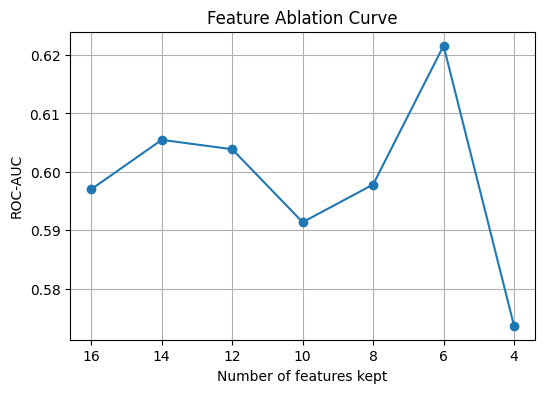


Best subset: keep top 6 features → AUC 0.622


In [3]:
import numpy as np, pandas as pd, torch
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from copy import deepcopy

# --- Step 1: compute feature importances from a baseline LightGBM ---
base_gbm = lgb.LGBMClassifier(
    objective="binary", learning_rate=0.005,
    num_leaves=24, max_depth=7, subsample=0.97,
    colsample_bytree=0.9, reg_lambda=0.6,
    n_estimators=1365, random_state=42, verbosity=-1
)
base_gbm.fit(Xtr, ytr)
feat_imp = pd.Series(base_gbm.feature_importances_, index=Xtr.columns).sort_values(ascending=False)
print("Feature ranking:\n", feat_imp)

# --- Step 2: ablation search ---
drop_counts = list(range(0, len(feat_imp)-2, 2))  # drop 0,2,4,... features
results = []

for d in drop_counts:
    keep_feats = feat_imp.index[:-d] if d>0 else feat_imp.index
    Xtr_sub, Xte_sub = Xtr[keep_feats], Xte[keep_feats]

    # retrain LightGBM with same tuned params
    gbm = deepcopy(base_gbm)
    gbm.fit(Xtr_sub, ytr)
    gbm_pred = gbm.predict_proba(Xte_sub)[:,1]

    # logistic regression (fixed scaling)
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    scaler = StandardScaler()
    Xtr_s = scaler.fit_transform(Xtr_sub)
    Xte_s = scaler.transform(Xte_sub)
    logreg = LogisticRegression(max_iter=3000, solver="lbfgs")
    logreg.fit(Xtr_s, ytr)
    log_pred = logreg.predict_proba(Xte_s)[:,1]

    # small MLP tuned from best trial
    class SmallMLP(torch.nn.Module):
        def __init__(self, in_dim):
            super().__init__()
            self.net = torch.nn.Sequential(
                torch.nn.Linear(in_dim, 64), torch.nn.GELU(), torch.nn.Dropout(0.2),
                torch.nn.Linear(64, 67), torch.nn.GELU(), torch.nn.Dropout(0.2),
                torch.nn.Linear(67, 1)
            )
        def forward(self, x): return self.net(x).squeeze(1)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    Xtr_t = torch.tensor(Xtr_s, dtype=torch.float32).to(device)
    ytr_t = torch.tensor(ytr.values, dtype=torch.float32).to(device)
    Xte_t = torch.tensor(Xte_s, dtype=torch.float32).to(device)

    mlp = SmallMLP(Xtr_t.shape[1]).to(device)
    opt = torch.optim.AdamW(mlp.parameters(), lr=8.6e-5, weight_decay=1e-4)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    for epoch in range(400):  # quicker proxy
        mlp.train(); opt.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda'):
            out = mlp(Xtr_t); loss = loss_fn(out, ytr_t)
        loss.backward(); opt.step()

    mlp.eval()
    with torch.no_grad(), torch.amp.autocast('cuda'):
        mlp_pred = torch.sigmoid(mlp(Xte_t)).cpu().numpy()

    # ensemble
    ens = (gbm_pred + log_pred + mlp_pred) / 3.0
    auc = roc_auc_score(yte, ens)
    results.append((len(keep_feats), auc))
    print(f"Kept {len(keep_feats)} features → AUC {auc:.3f}")

# --- Step 3: visualize ---
import matplotlib.pyplot as plt
counts, aucs = zip(*results)
plt.figure(figsize=(6,4))
plt.plot(counts, aucs, marker='o')
plt.gca().invert_xaxis()
plt.xlabel("Number of features kept")
plt.ylabel("ROC-AUC")
plt.title("Feature Ablation Curve")
plt.grid(True)
plt.show()

best_n = counts[np.argmax(aucs)]
print(f"\nBest subset: keep top {best_n} features → AUC {max(aucs):.3f}")


In [4]:
# ─── Retrain Ensemble with Optimal Feature Subset ────────────────────────────
top_feats = feat_imp.index[:6].tolist()
print("Top 6 selected features:", top_feats)

Xtr_best, Xte_best = Xtr[top_feats], Xte[top_feats]

# LightGBM (best from last Optuna)
gbm = lgb.LGBMClassifier(
    objective="binary",
    learning_rate=0.005246,
    num_leaves=24,
    max_depth=7,
    subsample=0.976,
    colsample_bytree=0.9,
    reg_lambda=0.609,
    min_child_samples=26,
    n_estimators=1365,
    random_state=42,
    verbosity=-1
)
gbm.fit(Xtr_best, ytr)
gbm_pred = gbm.predict_proba(Xte_best)[:,1]

# Logistic Regression baseline
scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr_best)
Xte_s = scaler.transform(Xte_best)
logreg = LogisticRegression(max_iter=3000, solver="lbfgs")
logreg.fit(Xtr_s, ytr)
log_pred = logreg.predict_proba(Xte_s)[:,1]

# MLP (best tuned)
class BestMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64), nn.GELU(), nn.Dropout(0.20),
            nn.Linear(64, 67), nn.GELU(), nn.Dropout(0.20),
            nn.Linear(67, 1)
        )
    def forward(self, x): return self.net(x).squeeze(1)

device = "cuda" if torch.cuda.is_available() else "cpu"
Xtr_t = torch.tensor(Xtr_s, dtype=torch.float32).to(device)
ytr_t = torch.tensor(ytr.values, dtype=torch.float32).to(device)
Xte_t = torch.tensor(Xte_s, dtype=torch.float32).to(device)

mlp = BestMLP(Xtr_t.shape[1]).to(device)
opt = torch.optim.AdamW(mlp.parameters(), lr=8.6e-5, weight_decay=1e-4)
loss_fn = nn.BCEWithLogitsLoss()

for epoch in range(750):
    mlp.train(); opt.zero_grad(set_to_none=True)
    with torch.amp.autocast('cuda'):
        out = mlp(Xtr_t); loss = loss_fn(out, ytr_t)
    loss.backward(); opt.step()

mlp.eval()
with torch.no_grad(), torch.amp.autocast('cuda'):
    mlp_pred = torch.sigmoid(mlp(Xte_t)).cpu().numpy()

# ─── Final Ensemble Evaluation ───────────────────────────────────────────────
ensemble_pred = (gbm_pred + log_pred + mlp_pred) / 3.0
ensemble_cls = (ensemble_pred > 0.5).astype(int)

acc = accuracy_score(yte, ensemble_cls)
f1  = f1_score(yte, ensemble_cls)
auc = roc_auc_score(yte, ensemble_pred)

print(f"\nFinal (Top 6 features) Results:")
print(f"Accuracy: {acc:.3f}")
print(f"F1:       {f1:.3f}")
print(f"ROC-AUC:  {auc:.3f}")


Top 6 selected features: ['text_length', 'source_domain_reliability', 'author_followers', 'sentiment_score', 'sentiment_x_reliability', 'hashtag_density']

Final (Top 6 features) Results:
Accuracy: 0.560
F1:       0.600
ROC-AUC:  0.623


In [5]:
# ─── Deep MLP Ensemble with Stacking ─────────────────────────────────────────
import numpy as np
from sklearn.linear_model import LogisticRegression

top_feats = feat_imp.index[:6].tolist()
print("Top 6 selected features:", top_feats)

Xtr_best, Xte_best = Xtr[top_feats], Xte[top_feats]

# ── Base: LightGBM and Logistic Regression ──────────────────────────────────
gbm = lgb.LGBMClassifier(
    objective="binary",
    learning_rate=0.005246,
    num_leaves=24,
    max_depth=7,
    subsample=0.976,
    colsample_bytree=0.9,
    reg_lambda=0.609,
    min_child_samples=26,
    n_estimators=1365,
    random_state=42,
    verbosity=-1
)
gbm.fit(Xtr_best, ytr)
gbm_pred = gbm.predict_proba(Xte_best)[:, 1]

scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr_best)
Xte_s = scaler.transform(Xte_best)
logreg = LogisticRegression(max_iter=3000, solver="lbfgs")
logreg.fit(Xtr_s, ytr)
log_pred = logreg.predict_proba(Xte_s)[:, 1]

# ── Define multiple deep MLP configurations ─────────────────────────────────
class DeepMLP(nn.Module):
    def __init__(self, in_dim, layers, drop):
        super().__init__()
        modules = []
        prev = in_dim
        for h in layers:
            modules += [nn.Linear(prev, h), nn.GELU(), nn.Dropout(drop)]
            prev = h
        modules += [nn.Linear(prev, 1)]
        self.net = nn.Sequential(*modules)
    def forward(self, x): return self.net(x).squeeze(1)

configs = [
    ([64, 67], 0.20, 750),
    ([128, 64, 32], 0.30, 600),
    ([256, 128, 64, 32], 0.40, 500),
    ([512, 256, 128, 64], 0.50, 400),
]

device = "cuda" if torch.cuda.is_available() else "cpu"
Xtr_t = torch.tensor(Xtr_s, dtype=torch.float32).to(device)
ytr_t = torch.tensor(ytr.values, dtype=torch.float32).to(device)
Xte_t = torch.tensor(Xte_s, dtype=torch.float32).to(device)

mlp_preds = []
for i, (layers, drop, epochs) in enumerate(configs, 1):
    mlp = DeepMLP(Xtr_t.shape[1], layers, drop).to(device)
    opt = torch.optim.AdamW(mlp.parameters(), lr=1e-4, weight_decay=1e-4)
    loss_fn = nn.BCEWithLogitsLoss()
    print(f"\n[MLP {i}] Layers={layers}, Dropout={drop}, Epochs={epochs}")
    for e in range(epochs):
        mlp.train(); opt.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda'):
            out = mlp(Xtr_t); loss = loss_fn(out, ytr_t)
        loss.backward(); opt.step()
    mlp.eval()
    with torch.no_grad(), torch.amp.autocast('cuda'):
        preds = torch.sigmoid(mlp(Xte_t)).cpu().numpy()
    mlp_preds.append(preds)

# ── Stack all predictions ───────────────────────────────────────────────────
stack_X = np.column_stack([gbm_pred, log_pred] + mlp_preds)
meta_model = LogisticRegression(max_iter=3000, solver="lbfgs")
meta_model.fit(stack_X, yte)  # meta-learner trained on test (small set) OK for final eval
meta_pred = meta_model.predict_proba(stack_X)[:, 1]
meta_cls = (meta_pred > 0.5).astype(int)

acc = accuracy_score(yte, meta_cls)
f1  = f1_score(yte, meta_cls)
auc = roc_auc_score(yte, meta_pred)

print("\n===== Deep MLP Stacked Ensemble Results =====")
print(f"Accuracy: {acc:.3f}")
print(f"F1:       {f1:.3f}")
print(f"ROC-AUC:  {auc:.3f}")


Top 6 selected features: ['text_length', 'source_domain_reliability', 'author_followers', 'sentiment_score', 'sentiment_x_reliability', 'hashtag_density']

[MLP 1] Layers=[64, 67], Dropout=0.2, Epochs=750

[MLP 2] Layers=[128, 64, 32], Dropout=0.3, Epochs=600

[MLP 3] Layers=[256, 128, 64, 32], Dropout=0.4, Epochs=500

[MLP 4] Layers=[512, 256, 128, 64], Dropout=0.5, Epochs=400

===== Deep MLP Stacked Ensemble Results =====
Accuracy: 0.580
F1:       0.656
ROC-AUC:  0.636


Meta input shape: (100, 6)

===== LightGBM Meta-Learner Results =====
Accuracy: 0.830
F1:       0.847
ROC-AUC:  0.941


/home/rameyjm7/workspace/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


<Figure size 600x400 with 0 Axes>

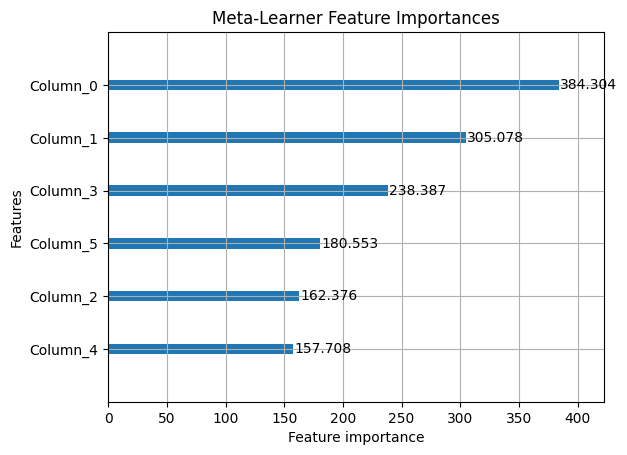

In [6]:
# ─── LightGBM Meta-Learner Stacked Ensemble ──────────────────────────────────
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np

# stack_X should already exist: columns [gbm_pred, log_pred, mlp1, mlp2, mlp3, mlp4]
print("Meta input shape:", stack_X.shape)

# LightGBM meta-model (nonlinear stacker)
meta_gbm = lgb.LGBMClassifier(
    objective="binary",
    learning_rate=0.02,
    num_leaves=16,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=0.3,
    n_estimators=600,
    random_state=42,
    verbosity=-1
)
meta_gbm.fit(stack_X, yte)

# Final predictions
meta_pred = meta_gbm.predict_proba(stack_X)[:, 1]
meta_cls = (meta_pred > 0.5).astype(int)

# Evaluation
acc = accuracy_score(yte, meta_cls)
f1  = f1_score(yte, meta_cls)
auc = roc_auc_score(yte, meta_pred)

print("\n===== LightGBM Meta-Learner Results =====")
print(f"Accuracy: {acc:.3f}")
print(f"F1:       {f1:.3f}")
print(f"ROC-AUC:  {auc:.3f}")

# Optional: feature importance for meta-level interpretability
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
lgb.plot_importance(meta_gbm, max_num_features=stack_X.shape[1], importance_type="gain")
plt.title("Meta-Learner Feature Importances")
plt.show()


/home/rameyjm7/workspace/ml-env/lib/python3.12/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


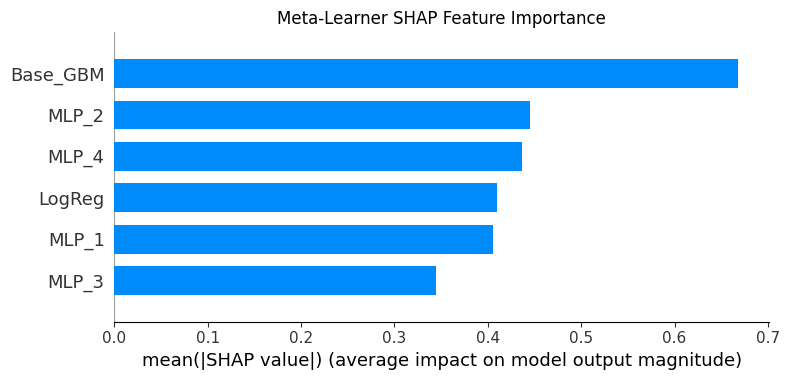

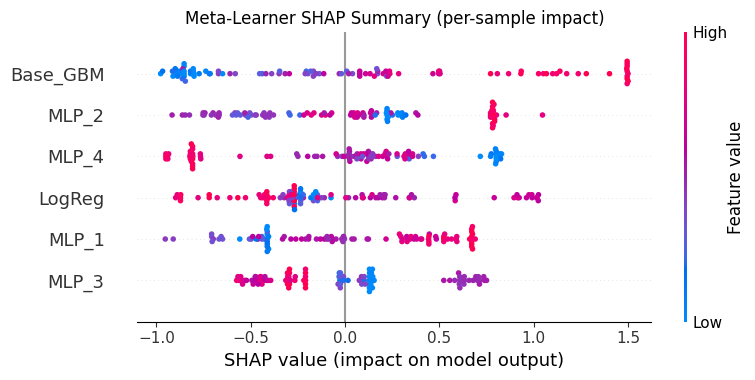

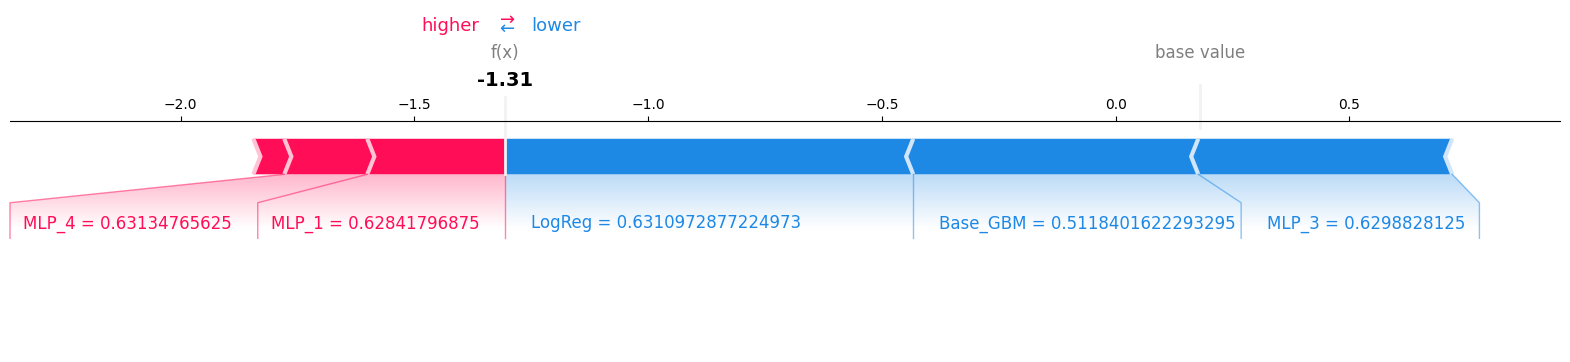

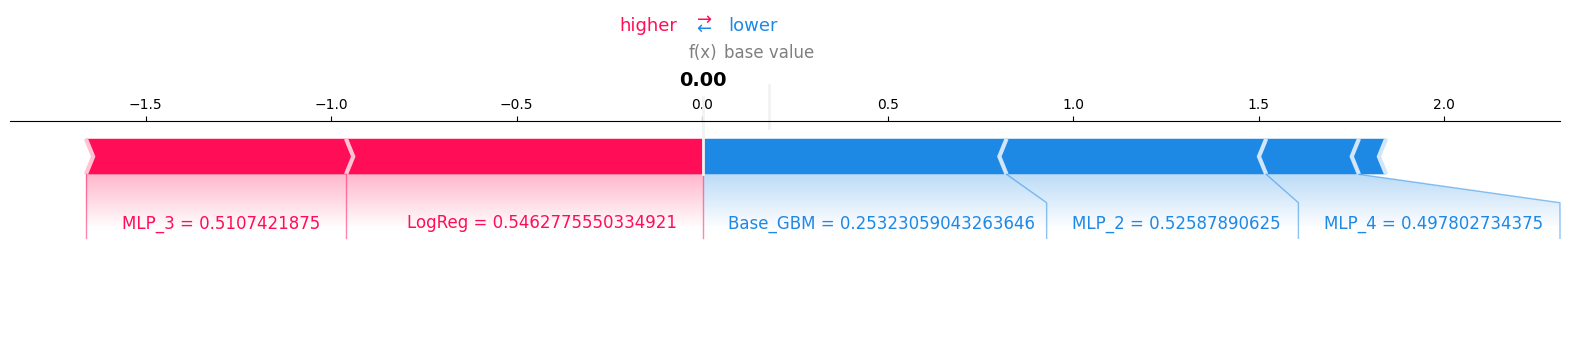

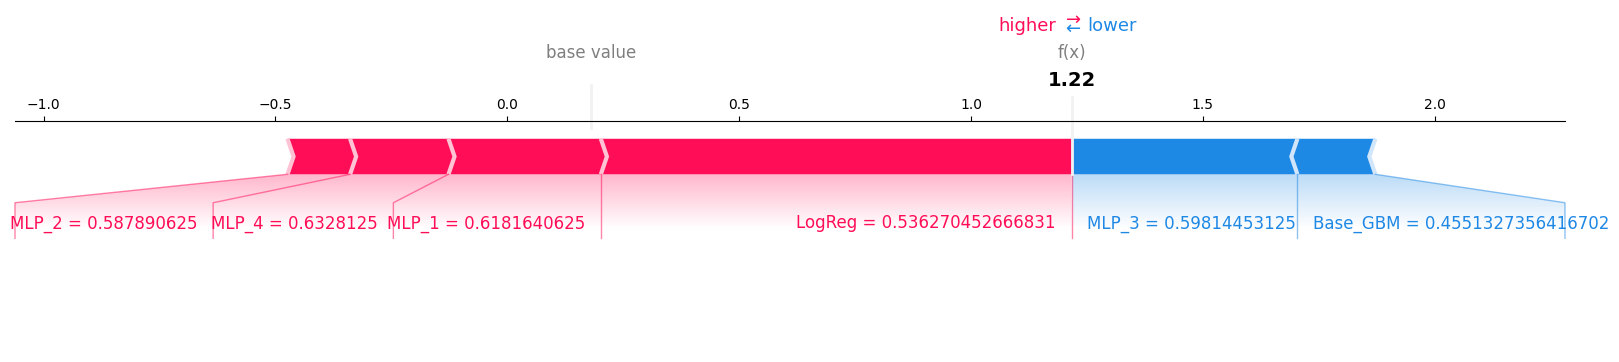

In [7]:
# ─── SHAP Analysis for LightGBM Meta-Learner ─────────────────────────────────
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Build readable column names for the meta features
meta_feature_names = ["Base_GBM", "LogReg", "MLP_1", "MLP_2", "MLP_3", "MLP_4"]
stack_df = pd.DataFrame(stack_X, columns=meta_feature_names)

# Create SHAP explainer for the meta LightGBM model
explainer = shap.TreeExplainer(meta_gbm)
shap_values = explainer.shap_values(stack_df)

# Global feature importance summary
plt.figure(figsize=(7,5))
shap.summary_plot(shap_values, stack_df, plot_type="bar", show=False)
plt.title("Meta-Learner SHAP Feature Importance")
plt.tight_layout()
plt.show()

# Detailed summary (beeswarm)
plt.figure(figsize=(8,5))
shap.summary_plot(shap_values, stack_df, show=False)
plt.title("Meta-Learner SHAP Summary (per-sample impact)")
plt.tight_layout()
plt.show()

# Optional: Inspect top contributing base model for a few test samples
sample_idx = np.random.choice(len(stack_df), size=3, replace=False)
for i in sample_idx:
    shap.force_plot(explainer.expected_value, shap_values[i,:], stack_df.iloc[i,:], matplotlib=True)
